In [1]:
import pandas as pd
import numpy as np
import json
import nltk
import re
import csv
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

%matplotlib inline
pd.set_option('display.max_colwidth', 300)

In [2]:
meta = pd.read_csv("../../Resources/MovieSummaries.tar/MovieSummaries/movie.metadata.tsv", sep = '\t', header = None)
meta.head()

,0,1,2,3,4,5,6,7,8
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science Fiction"", ""/m/03npn"": ""Horror"", ""/m/03k9fj"": ""Adventure"", ""/m/0fdjb"": ""Supernatural"", ""/m/02kdv5l"": ""Action"", ""/m/09zvmj"": ""Space western""}"
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey Mystery,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0"": ""Drama"", ""/m/0hj3n01"": ""Crime Drama""}"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""Drama""}"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic thriller"", ""/m/09blyk"": ""Psychological thriller""}"
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [3]:
meta.columns = ["movie_id",1,"movie_name",3,4,5,6,7,"genre"]
meta.head()

,movie_id,1,movie_name,3,4,5,6,7,genre
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science Fiction"", ""/m/03npn"": ""Horror"", ""/m/03k9fj"": ""Adventure"", ""/m/0fdjb"": ""Supernatural"", ""/m/02kdv5l"": ""Action"", ""/m/09zvmj"": ""Space western""}"
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey Mystery,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0"": ""Drama"", ""/m/0hj3n01"": ""Crime Drama""}"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""Drama""}"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic thriller"", ""/m/09blyk"": ""Psychological thriller""}"
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [4]:
plots = []

with open("../Resources/MovieSummaries.tar/MovieSummaries/plot_summaries.txt", 'r', encoding="utf8") as f:
       reader = csv.reader(f, dialect='excel-tab') 
       for row in tqdm(reader):
            plots.append(row)

42303it [00:01, 32108.86it/s]


In [5]:
movie_id = []
plot = []

# extract movie Ids and plot summaries
for i in tqdm(plots):
  movie_id.append(i[0])
  plot.append(i[1])

# create dataframe
movies = pd.DataFrame({'movie_id': movie_id, 'plot': plot})

100%|██████████| 42303/42303 [00:00<00:00, 1262238.77it/s]


In [13]:
movies.head(5)

,movie_id,plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all."
1,31186339,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole..."
2,20663735,"Poovalli Induchoodan is sentenced for six years prison life for murdering his classmate. Induchoodan, the only son of Justice Maranchery Karunakara Menon was framed in the case by Manapally Madhavan Nambiar and his crony DYSP Sankaranarayanan to take revenge on idealist judge Menon who had e..."
3,2231378,"The Lemon Drop Kid , a New York City swindler, is illegally touting horses at a Florida racetrack. After several successful hustles, the Kid comes across a beautiful, but gullible, woman intending to bet a lot of money. The Kid convinces her to switch her bet, employing a prefabricated con. Unfo..."
4,595909,"Seventh-day Adventist Church pastor Michael Chamberlain, his wife Lindy, their two sons, and their nine-week-old daughter Azaria are on a camping holiday in the Outback. With the baby sleeping in their tent, the family is enjoying a barbecue with their fellow campers when a cry is heard. Lindy r..."


In [6]:
meta['movie_id'] = meta['movie_id'].astype(str)

# merge meta with movies
movies = pd.merge(movies, meta[['movie_id', 'movie_name', 'genre']], on = 'movie_id')

movies.head()

,movie_id,plot,movie_name,genre
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all.",Taxi Blues,"{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World cinema""}"
1,31186339,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole...",The Hunger Games,"{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"": ""Science Fiction"", ""/m/02kdv5l"": ""Action"", ""/m/07s9rl0"": ""Drama""}"
2,20663735,"Poovalli Induchoodan is sentenced for six years prison life for murdering his classmate. Induchoodan, the only son of Justice Maranchery Karunakara Menon was framed in the case by Manapally Madhavan Nambiar and his crony DYSP Sankaranarayanan to take revenge on idealist judge Menon who had e...",Narasimham,"{""/m/04t36"": ""Musical"", ""/m/02kdv5l"": ""Action"", ""/m/07s9rl0"": ""Drama"", ""/m/01chg"": ""Bollywood""}"
3,2231378,"The Lemon Drop Kid , a New York City swindler, is illegally touting horses at a Florida racetrack. After several successful hustles, the Kid comes across a beautiful, but gullible, woman intending to bet a lot of money. The Kid convinces her to switch her bet, employing a prefabricated con. Unfo...",The Lemon Drop Kid,"{""/m/06qm3"": ""Screwball comedy"", ""/m/01z4y"": ""Comedy""}"
4,595909,"Seventh-day Adventist Church pastor Michael Chamberlain, his wife Lindy, their two sons, and their nine-week-old daughter Azaria are on a camping holiday in the Outback. With the baby sleeping in their tent, the family is enjoying a barbecue with their fellow campers when a cry is heard. Lindy r...",A Cry in the Dark,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""Drama"", ""/m/01f9r0"": ""Docudrama"", ""/m/03q4nz"": ""World cinema"", ""/m/05bh16v"": ""Courtroom Drama""}"


In [7]:
genres = [] 

# extract genres
for i in movies['genre']: 
  genres.append(list(json.loads(i).values())) 

# add to 'movies' dataframe  
movies['genre_new'] = genres

In [8]:
movies_new = movies[~(movies['genre_new'].str.len() == 0)]

In [9]:
all_genres = sum(genres,[])
len(set(all_genres))
all_genres = nltk.FreqDist(all_genres) 

# create dataframe
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 
                              'Count': list(all_genres.values())})

In [49]:
for g in all_genres.keys():
    print(g)

Drama
World cinema
Action/Adventure
Science Fiction
Action
Musical
Bollywood
Screwball comedy
Comedy
Crime Fiction
Docudrama
Courtroom Drama
Thriller
Horror
Teen
Romantic comedy
Media Satire
Americana
Comedy-drama
Black-and-white
Romance Film
Short Film
Family Film
Animation
Parody
War film
Epic
Period piece
Film adaptation
Political drama
Cult
Coming of age
Mystery
Comedy film
Indie
Martial Arts Film
Computer Animation
Adventure
Documentary
History
Biopic [feature]
Family Drama
B-movie
Slasher
Western
Buddy film
Costume Adventure
Historical Epic
Chinese Movies
Crime Thriller
Musical comedy
Beach Film
Wuxia
Fantasy Adventure
Superhero movie
Fantasy
Romantic fantasy
Black comedy
Satire
Romantic drama
Silent film
Experimental film
Musical Drama
Avant-garde
LGBT
Gay
Spy
Melodrama
Natural horror films
Television movie
Comedy of manners
Tragicomedy
Sports
Children's/Family
Children's
Music
Family-Oriented Adventure
Slapstick
Fantasy Comedy
Domestic Comedy
Psychological thriller
Psycho-biddy

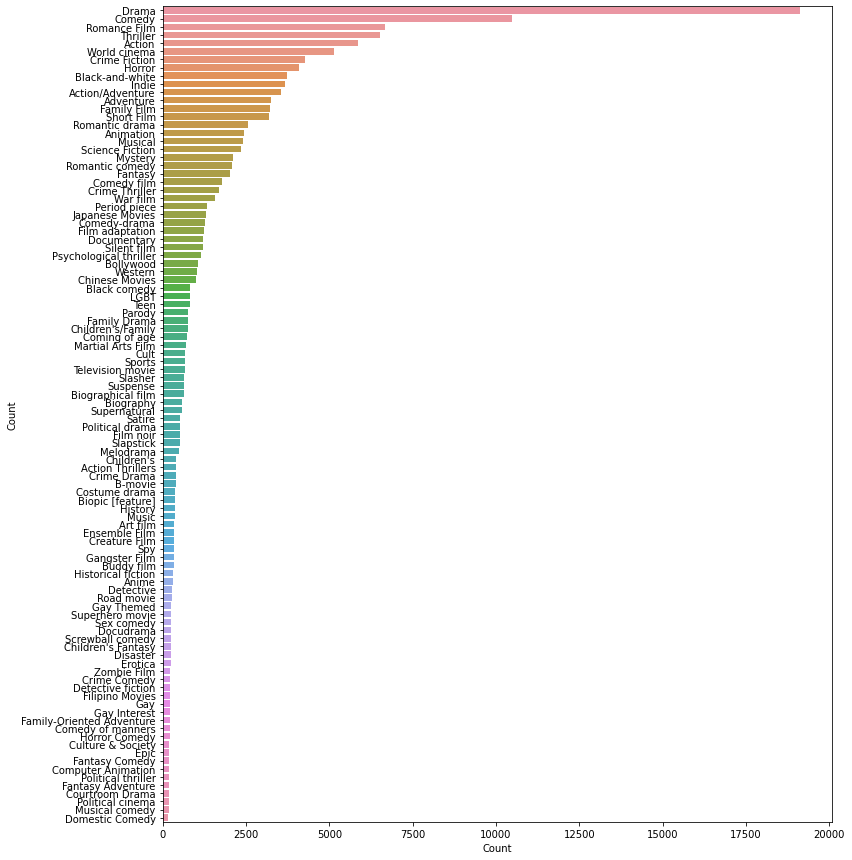

In [27]:
g = all_genres_df.nlargest(columns="Count", n = 100) 
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=g, x= "Count", y = "Genre") 
ax.set(ylabel = 'Count') 
plt.show()

In [10]:
def clean_text(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text

In [11]:
movies_new['clean_plot'] = movies_new['plot'].apply(lambda x: clean_text(x))

<ipython-input-11-cba7721b10bf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_new['clean_plot'] = movies_new['plot'].apply(lambda x: clean_text(x))


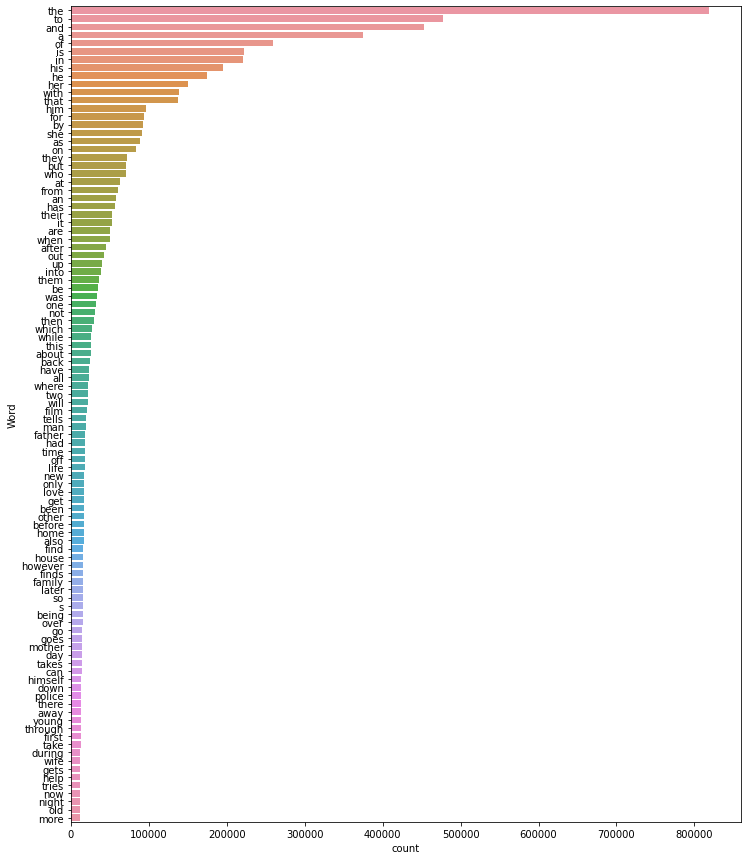

In [12]:
def freq_words(x, terms = 30): 
  all_words = ' '.join([text for text in x]) 
  all_words = all_words.split() 
  fdist = nltk.FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  # selecting top 20 most frequent words 
  d = words_df.nlargest(columns="count", n = terms) 
  
  # visualize words and frequencies
  plt.figure(figsize=(12,15)) 
  ax = sns.barplot(data=d, x= "count", y = "word") 
  ax.set(ylabel = 'Word') 
  plt.show()
  
# print 100 most frequent words 
freq_words(movies_new['clean_plot'], 100)

In [13]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ameer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

movies_new['clean_plot'] = movies_new['clean_plot'].apply(lambda x: remove_stopwords(x))

<ipython-input-14-19c73b0b723d>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_new['clean_plot'] = movies_new['clean_plot'].apply(lambda x: remove_stopwords(x))


In [15]:
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(movies_new['genre_new'])

# transform target variable
y = multilabel_binarizer.transform(movies_new['genre_new'])

In [16]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)

In [17]:
xtrain, xval, ytrain, yval = train_test_split(movies_new['clean_plot'], y, test_size=0.2, random_state=9)

In [18]:
# create TF-IDF features
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)

Building the model


In [19]:
from sklearn.linear_model import LogisticRegression

# Binary Relevance
from sklearn.multiclass import OneVsRestClassifier

# Performance metric
from sklearn.metrics import f1_score

In [20]:
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

In [21]:
# fit model on train data
clf.fit(xtrain_tfidf, ytrain)

In [ ]:
# make predictions for validation set
y_pred = clf.predict(xval_tfidf)

In [ ]:
multilabel_binarizer.inverse_transform(y_pred)[3]

C:\Users\ameer\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\multiclass.py:80: UserWarning: Label not 48 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


C:\Users\ameer\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\multiclass.py:80: UserWarning: Label not 182 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


In [ ]:
# evaluate performance
f1_score(yval, y_pred, average="micro")

In [25]:
# predict probabilities
y_pred_prob = clf.predict_proba(xval_tfidf)

C:\Users\ameer\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\multiclass.py:80: UserWarning: Label not 214 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


C:\Users\ameer\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\multiclass.py:80: UserWarning: Label not 245 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


OneVsRestClassifier(estimator=LogisticRegression())

('Action', 'Drama')

0.3156683206302113

In [26]:
t = 0.3 # threshold value
y_pred_new = (y_pred_prob >= t).astype(int)

In [27]:
# evaluate performance
f1_score(yval, y_pred_new, average="micro")

0.437668381092334

In [28]:
def infer_tags(q):
    q = clean_text(q)
    q = remove_stopwords(q)
    q_vec = tfidf_vectorizer.transform([q])
    q_pred = clf.predict(q_vec)
    return multilabel_binarizer.inverse_transform(q_pred)

In [29]:
for i in range(5): 
  k = xval.sample(1).index[0] 
  print("Movie: ", movies_new['movie_name'][k], "\nPredicted genre: ", infer_tags(xval[k])), print("Actual genre: ",movies_new['genre_new'][k], "\n")


Movie:  Indochine 
Predicted genre:  [('Drama',)]
Actual genre:  ['World cinema', 'Epic', 'Drama', 'War film', 'Romantic drama', 'Romance Film'] 

Movie:  Train of Life 
Predicted genre:  [()]
Actual genre:  ['Tragicomedy', 'Romance Film', 'Comedy-drama', 'Comedy', 'War film'] 

Movie:  Heartbreakers 
Predicted genre:  [('Comedy',)]
Actual genre:  ['Drama'] 

Movie:  While I Live 
Predicted genre:  [('Drama',)]
Actual genre:  ['Thriller', 'Drama'] 

Movie:  Cheerleader Queens 
Predicted genre:  [('Comedy', 'Sports')]
Actual genre:  ['LGBT'] 



In [50]:
movies_new.head(5)

,movie_id,plot,movie_name,genre,genre_new,clean_plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all.",Taxi Blues,"{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World cinema""}","[Drama, World cinema]",shlykov hard working taxi driver lyosha saxophonist develop bizarre love hate relationship despite prejudices realize arent different
1,31186339,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole...",The Hunger Games,"{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"": ""Science Fiction"", ""/m/02kdv5l"": ""Action"", ""/m/07s9rl0"": ""Drama""}","[Action/Adventure, Science Fiction, Action, Drama]",nation panem consists wealthy capitol twelve poorer districts punishment past rebellion district must provide boy girl ages selected lottery annual hunger games tributes must fight death arena sole survivor rewarded fame wealth first reaping year old primrose everdeen chosen district older siste...
2,20663735,"Poovalli Induchoodan is sentenced for six years prison life for murdering his classmate. Induchoodan, the only son of Justice Maranchery Karunakara Menon was framed in the case by Manapally Madhavan Nambiar and his crony DYSP Sankaranarayanan to take revenge on idealist judge Menon who had e...",Narasimham,"{""/m/04t36"": ""Musical"", ""/m/02kdv5l"": ""Action"", ""/m/07s9rl0"": ""Drama"", ""/m/01chg"": ""Bollywood""}","[Musical, Action, Drama, Bollywood]",poovalli induchoodan sentenced six years prison life murdering classmate induchoodan son justice maranchery karunakara menon framed case manapally madhavan nambiar crony dysp sankaranarayanan take revenge idealist judge menon earlier given jail sentence manapally corruption case induchoodan achi...
3,2231378,"The Lemon Drop Kid , a New York City swindler, is illegally touting horses at a Florida racetrack. After several successful hustles, the Kid comes across a beautiful, but gullible, woman intending to bet a lot of money. The Kid convinces her to switch her bet, employing a prefabricated con. Unfo...",The Lemon Drop Kid,"{""/m/06qm3"": ""Screwball comedy"", ""/m/01z4y"": ""Comedy""}","[Screwball comedy, Comedy]",lemon drop kid new york city swindler illegally touting horses florida racetrack several successful hustles kid comes across beautiful gullible woman intending bet lot money kid convinces switch bet employing prefabricated con unfortunately kid woman belongs notorious gangster moose moran money ...
4,595909,"Seventh-day Adventist Church pastor Michael Chamberlain, his wife Lindy, their two sons, and their nine-week-old daughter Azaria are on a camping holiday in the Outback. With the baby sleeping in their tent, the family is enjoying a barbecue with their fellow campers when a cry is heard. Lindy r...",A Cry in the Dark,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""Drama"", ""/m/01f9r0"": ""Docudrama"", ""/m/03q4nz"": ""World cinema"", ""/m/05bh16v"": ""Courtroom Drama""}","[Crime Fiction, Drama, Docudrama, World cinema, Courtroom Drama]",seventh day adventist church pastor michael chamberlain wife lindy two sons nine week old daughter azaria camping holiday outback baby sleeping tent family enjoying barbecue fellow campers cry heard lindy returns tent check azaria certain sees dingo something mouth running approaches discovers i...


In [36]:
movies_df = pd.read_csv('../Resources/modified_movies.csv',low_memory=False)
movies_df.sort_values(by=['avg_vote'], inplace=True, ascending=False)
movies_df.head(5)

,Unnamed: 0,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,...,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics,id,encoded_genre,writer_encoded,director_encoded
26888,26888,tt7822474,Suvarna Sundari,Suvarna Sundari,2019,2019-05-31,"['Action', 'Thriller']",120,India,"Telugu, Kannada",...,NaN,NaN,NaN,NaN,NaN,2.0,26888,[ 0 20],[0],[7959]
27401,27401,tt9008642,Notuku Potu,Notuku Potu,2017,2017-03-24,"['Horror', 'Mystery']",121,India,Telugu,...,NaN,NaN,NaN,NaN,2.0,1.0,27401,[12 15],[0],[1248]
19774,19774,tt11976170,Jeeudo,Jeeudo,2020,2020-02-27,"['Drama', 'Romance']",150,India,"English, Nepali",...,INR 4700000,NaN,NaN,NaN,114.0,NaN,19774,[ 7 17],[ 40 3222],[21]
19959,19959,tt12492650,Ek,Ek,2019,2019-06-14,"['Action', 'Drama']",129,India,Telugu,...,INR 20000000,NaN,NaN,NaN,NaN,NaN,19959,[0 7],[7753],[10060]
19452,19452,tt11207902,Lejos de Casa pelicula Venezolana,Lejos de Casa pelicula Venezolana,2020,2020-03-19,"['Drama', 'History']",87,Venezuela,Spanish,...,$ 5000,NaN,NaN,NaN,NaN,NaN,19452,[ 7 11],[4262 133],[76]


In [56]:
extended_genre =[]
for m in movies_df['original_title']:
        if m in list(movies_new['movie_name']):
                extended_genre.append(movies_new.loc[movies_new['movie_name'] == m]['genre_new'])
        else:
                extended_genre.append(None)



In [57]:
movies_df['extended_genre'] =  extended_genre

In [58]:
movies_df.columns

Index(['Unnamed: 0', 'imdb_title_id', 'title', 'original_title', 'year',
       'date_published', 'genre', 'duration', 'country', 'language',
       'director', 'writer', 'production_company', 'actors', 'description',
       'avg_vote', 'votes', 'budget', 'usa_gross_income',
       'worlwide_gross_income', 'metascore', 'reviews_from_users',
       'reviews_from_critics', 'id', 'encoded_genre', 'writer_encoded',
       'director_encoded', 'extended_genre'],
      dtype='object')

In [68]:
def change(row):
    if(row['extended_genre'] is None ):
        r = infer_tags(row['description'])
    else:
        r = row['extended_genre']
        print(row['extended_genre'])

    return r

#movies_df.apply(lambda x: change(x))

In [69]:
results = movies_df.apply(change, axis=1)

In [70]:
print(results)

26888                           [()]
27401                  [(Thriller,)]
19774        [(Drama, Romance Film)]
19959                     [(Drama,)]
19452                     [(Drama,)]
                    ...             
18299                           [()]
9696     [(Horror, Science Fiction)]
25236                           [()]
9693                            [()]
13837                    [(Horror,)]
Length: 27675, dtype: object


In [72]:
movies_df['extended_genre'] = results
movies_df.head(20)

,Unnamed: 0,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,...,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics,id,encoded_genre,writer_encoded,director_encoded,extended_genre
26888,26888,tt7822474,Suvarna Sundari,Suvarna Sundari,2019,2019-05-31,"['Action', 'Thriller']",120,India,"Telugu, Kannada",...,NaN,NaN,NaN,NaN,2.0,26888,[ 0 20],[0],[7959],[()]
27401,27401,tt9008642,Notuku Potu,Notuku Potu,2017,2017-03-24,"['Horror', 'Mystery']",121,India,Telugu,...,NaN,NaN,NaN,2.0,1.0,27401,[12 15],[0],[1248],"[(Thriller,)]"
19774,19774,tt11976170,Jeeudo,Jeeudo,2020,2020-02-27,"['Drama', 'Romance']",150,India,"English, Nepali",...,NaN,NaN,NaN,114.0,NaN,19774,[ 7 17],[ 40 3222],[21],"[(Drama, Romance Film)]"
19959,19959,tt12492650,Ek,Ek,2019,2019-06-14,"['Action', 'Drama']",129,India,Telugu,...,NaN,NaN,NaN,NaN,NaN,19959,[0 7],[7753],[10060],"[(Drama,)]"
19452,19452,tt11207902,Lejos de Casa pelicula Venezolana,Lejos de Casa pelicula Venezolana,2020,2020-03-19,"['Drama', 'History']",87,Venezuela,Spanish,...,NaN,NaN,NaN,NaN,NaN,19452,[ 7 11],[4262 133],[76],"[(Drama,)]"
27237,27237,tt8571428,Vaarthakal Ithuvare,Vaarthakal Ithuvare,2019,2019-11-22,['Comedy'],121,India,Malayalam,...,NaN,NaN,NaN,20.0,NaN,27237,[4],[13134],[6990],[()]
20729,20729,tt1508669,Hopeful Notes,Hopeful Notes,2010,2010-12-15,['Drama'],94,USA,English,...,NaN,NaN,NaN,2.0,2.0,20729,[7],[21369],[11588],"[(Drama,)]"
20046,20046,tt12747588,Meka Suri,Meka Suri,2020,2020-07-31,"['Crime', 'Thriller']",86,India,Telugu,...,NaN,NaN,NaN,502.0,NaN,20046,[ 5 20],[0],[11461],[()]
19437,19437,tt11164090,The Moving on Phase,The Moving on Phase,2020,2020-05-11,['Comedy'],85,USA,English,...,NaN,NaN,NaN,NaN,NaN,19437,[4],[4945],[2760],"[(Drama,)]"
22998,22998,tt2673212,The Best Years,The Best Years,2013,2013-04-25,"['Comedy', 'Crime', 'Drama']",96,UK,English,...,NaN,NaN,NaN,NaN,NaN,22998,[4 5 7],[4243],[2362],[()]


In [73]:
movies.to_csv("../Resources/modified_movies.csv")

In [92]:


movies_df[movies_df['original_title'].str.contains('star wars', case=False)]

,Unnamed: 0,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,...,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics,id,encoded_genre,writer_encoded,director_encoded,extended_genre
8162,8162,tt0080684,L'Impero colpisce ancora,Star Wars: Episode V - The Empire Strikes Back,1980,1980-09-19,"['Action', 'Adventure', 'Fantasy']",124,USA,English,...,$ 291286960,$ 549265501,82.0,1229.0,228.0,8162,[0 1 9],[12268 12218],[4563],[()]
7708,7708,tt0076759,Guerre stellari,Star Wars,1977,1977-10-20,"['Action', 'Adventure', 'Fantasy']",121,USA,English,...,$ 460998507,$ 775768912,90.0,1852.0,192.0,7708,[0 1 9],[6839],[3642],"[(Action, Adventure)]"
8801,8801,tt0086190,Il ritorno dello Jedi,Star Wars: Episode VI - Return of the Jedi,1983,1983-10-21,"['Action', 'Adventure', 'Fantasy']",131,USA,English,...,$ 309306177,$ 475347111,58.0,839.0,202.0,8801,[0 1 9],[12218 6839],[9512],"[(Action,)]"
22818,22818,tt2488496,Star Wars - Il risveglio della Forza,Star Wars: Episode VII - The Force Awakens,2015,2015-12-16,"['Action', 'Adventure', 'Sci-Fi']",138,USA,English,...,$ 936662225,$ 2068224036,80.0,4822.0,909.0,22818,[ 0 1 18],[12218 8854],[4686],[()]
26781,26781,tt7640228,Inter Star Wars 2. The Last Jehi,Inter Star Wars 2. The Last Jehi,2017,2017-11-16,"['Action', 'Comedy', 'Horror']",48,"Russia, Ukraine",Russian,...,NaN,NaN,NaN,NaN,1.0,26781,[ 0 4 12],[19122 19067],[10290 10261],[()]
12099,12099,tt0121766,Star Wars: Episodio III - La vendetta dei Sith,Star Wars: Episode III - Revenge of the Sith,2005,2005-05-20,"['Action', 'Adventure', 'Fantasy']",140,USA,English,...,$ 380270577,$ 868390560,68.0,3569.0,391.0,12099,[0 1 9],[6839],[3642],[()]
22848,22848,tt2527336,Star Wars - Gli ultimi Jedi,Star Wars: Episode VIII - The Last Jedi,2017,2017-12-13,"['Action', 'Adventure', 'Fantasy']",152,USA,English,...,$ 620181382,$ 1332540187,84.0,6718.0,717.0,22848,[0 1 9],[17556 6839],[9452],[()]
24030,24030,tt3778644,Solo: A Star Wars Story,Solo: A Star Wars Story,2018,2018-05-23,"['Action', 'Adventure', 'Sci-Fi']",135,USA,English,...,$ 213767512,$ 392924807,62.0,2486.0,546.0,24030,[ 0 1 18],[10538 12218],[9816],"[(Action,)]"
22849,22849,tt2527338,Star Wars: L'ascesa di Skywalker,Star Wars: Episode IX - The Rise of Skywalker,2019,2019-12-18,"['Action', 'Adventure', 'Fantasy']",141,USA,English,...,$ 515202542,$ 1074144248,53.0,7553.0,502.0,22849,[0 1 9],[3529 8854],[4686],[()]
